# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [1]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdc       1007G   16G  941G   2% /
Disk space is sufficient: 941G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [2]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [3]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 wayyixuan wayyixuan 2.0G Jun 20 00:19 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [4]:
%%bash
source ~/.profile
cargo install hyperfine

    Updating crates.io index
     Ignored package `hyperfine v1.19.0` is already installed, use --force to override


有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [5]:
%%bash
source ~/.profile
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt


  Time (mean ± σ):     189.0 ms ±   5.5 ms    [User: 4.4 ms, System: 180.3 ms]
  Range (min … max):   180.2 ms … 199.4 ms    15 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [23]:
%%bash
source ~/.profile
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt
Process was interrupted.


CalledProcessError: Command 'b"source ~/.profile\nhyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'\n"' died with <Signals.SIGINT: 2>.

## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [8]:
%%bash
source ~/.profile
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):     440.0 ms ±  17.2 ms    [User: 45.5 ms, System: 391.1 ms]
  Range (min … max):   414.2 ms … 460.0 ms    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

### 问题回答：
1. 将缓冲区对齐到内存页边界可以提高性能，这主要归因于作系统和硬件管理内存的方式（虚拟内存管理和缓存）。缓存局部性： 当访问数据时，CPU 会将整个缓存行（通常为 64 字节）读入其缓存。 如果缓冲区正好从缓存行边界开始，第一次读取将用相关数据填充一个缓存行，从而最大限度地利用该缓存行。 如果不对齐，第一次读取可能会获取跨越两个缓存行的数据，可能引入不必要的数据并导致更多的缓存未命中。虚拟内存页作：作系统以页为单位将物理内存映射到虚拟内存。 许多与内存相关的作（如页错误、TLB 查找）都针对页对齐访问进行了优化。 当缓冲区页对齐时，作系统可以更有效地执行这些作，因为整个缓冲区或其大部分将位于最少数量的虚拟内存页中。 这可以减少 TLB 未命中并提高整体内存访问效率。直接内存访问 （DMA）： 对于高性能 I/O作，设备通常使用 DMA 直接在内存之间传输数据，无需 CPU 干预。 DMA 控制器通常在物理内存页上作。 如果 I/O 缓冲区是页对齐的，DMA 传输可以更有效，并可能避免作系统或硬件的额外复制。实验结果是否支持这一假设取决于您的具体系统和工作负载。 在许多现代系统上，对于简单的类作，性能差异可能可以忽略不计，特别是如果整体 I/O 瓶颈在其他地方（例如，磁盘速度、小缓冲区的 CPU 处理）。 对于非常大的文件和高 I/O 吞吐量场景，或特定硬件，对齐的好处可能会更加明显。 如果结果显示改进很小或没有改进，则可能是因为未对齐访问的开销在大量传输中被分摊了，或者现代 CPU 和作系统已经高度优化以减轻这些损失。

2. 为了提供通用内存分配。 虽然它通常返回对齐到某个 2 的幂（通常是 ，这对于标准数据类型如 、 或指针来说已经足够）的地址，但它不保证页对齐。通常从 C 运行时库管理的一个更大的堆中分配内存。 这个堆可能是一个使用 或 从作系统获取的大块内存。 然后， 将这个大块细分以满足较小的分配请求。 为了优化内存利用率并减少碎片， 内部算法可能会返回非页对齐的内存地址，即使存在一个可用的页对齐块。 主要目标是有效地管理通用内存，而不是提供超出 C 标准对基本类型要求以外的特定对齐保证。

3. 必须使用分配函数 (malloc、calloc、realloc、posix_memalign 等) 返回的确切指针来释放内存。如果您没有原始指针，则无法可靠地释放内存，从而导致内存泄漏或未定义行为（例如，双重释放、释放无效指针）。在 align_alloc 和 align_free 函数中：当使用 posix_memalign 时，该函数本身接受一个 void* 的指针，并用页对齐的地址填充它。然后，由 posix_memalign 分配的内存可以使用 free() 安全地释放。posix_memalign 的内部机制会记录原始的、可能未对齐的分配地址，以正确管理解除分配。作为调用者，您只需要知道它返回的页对齐指针。如果您手动对齐 malloc 分配的内存（例如，通过分配 size + page_size - 1，然后在该块内找到下一个页对齐地址），需要将 malloc 返回的原始指针与您提供给用户的对齐指针一起存储。然后，在 align_free 中，将使用该存储的原始 malloc 指针来调用 free()。这就是为什么 posix_memalign 更受欢迎的原因，因为它为您处理了这种复杂性。

In [9]:
%%bash
source ~/.profile
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):     433.3 ms ±  27.5 ms    [User: 40.5 ms, System: 388.5 ms]
  Range (min … max):   392.3 ms … 481.1 ms    10 runs
 


## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

### 回答问题：
1. 为什么在设置缓冲区大小时需要考虑文件系统块大小？
文件系统将数据组织在磁盘上的块中。当操作系统读写文件时，它通常以文件系统块为单位进行操作。

最佳 I/O 单位： 读写文件系统块倍数的数据量可以使文件系统更有效地执行 I/O 操作。它避免了“部分块”读/写，这可能需要读取整个块、修改其中一部分，然后将整个块写回（读-修改-写周期），效率较低。
减少开销： 通过将缓冲区大小与文件系统块大小对齐，我们最大限度地减少了 I/O 操作的数量以及相关的系统调用开销。每次读/写调用都会产生一定的开销，因此执行更少、更大、对齐的操作通常更快。
DMA 对齐： 与内存页对齐类似，一些磁盘控制器和文件系统针对块对齐的数据传输进行了优化，可能更有效地利用 DMA。

2. 您是如何处理上述两个注意事项的（文件系统块大小并非总是针对每个文件都相同，以及某些文件系统报告的虚假块大小不是 2 的幂）？

文件系统块大小并非总是相同： 这是事实，同一文件系统上的不同文件有时可能具有不同的最佳块大小，或者同一系统上挂载的不同文件系统将具有不同的块大小。fstat（或 Rust 中的 fstatvfs）中的 st_blksize 字段提供了针对该特定文件（或包含它的文件系统）的 I/O 的首选块大小。通过对特定输入文件 (test.txt) 调用 fstat，我们获得了与该文件相关的块大小，而不是假设一个全局默认值。这解决了文件和文件系统之间的可变性。
虚假块大小（不是 2 的幂）： 某些文件系统可能会报告不是 2 的幂的 st_blksize 值，这对于某些硬件或强烈偏好 2 的幂大小的内存对齐策略可能会有问题。

In [10]:
%%bash
source ~/.profile
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     445.6 ms ±  23.6 ms    [User: 44.4 ms, System: 398.8 ms]
  Range (min … max):   398.1 ms … 466.3 ms    10 runs
 


## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

### 设计思路：

这个实验脚本的目标是找出在系统调用开销影响下，数据传输的最佳缓冲区大小。我们知道，每次系统调用都有固定成本，因此过小的缓冲区会导致频繁调用，效率低下；但过大的缓冲区也可能不再带来显著收益。

为了纯粹测量系统调用和内存拷贝的效率，我们巧妙地使用了 dd 命令配合特殊设备文件：if=/dev/zero 作为输入源（无限提供零数据，无磁盘读取开销），of=/dev/null 作为输出目标（丢弃所有数据，无磁盘写入开销）。这模拟了一个纯粹的内存到内存的数据流，其中包含了用户态与内核态切换的系统调用开销。

脚本会测试一系列逐渐增大的缓冲区大小（从 4KB 到 4MB），每次固定传输 2GB 数据，并记录 dd 命令报告的传输速率。最后，它会将这些数据绘制成图表（X轴为对数刻度），直观展示传输速率如何随缓冲区增大而变化，并自动识别出达到最高效率时的“最佳”缓冲区大小，即性能曲线趋于平稳的那个点。

Initiating performance benchmark for DD command with varying buffer sizes...
Buffer Size (KB)   | Transfer Rate (MB/s)   | Raw dd Output (Relevant Line)
4.00               | 8089.60                | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.273423 s, 7.9 GB/s
8.00               | 12800.00               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.172275 s, 12.5 GB/s
16.00              | 17715.20               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.123887 s, 17.3 GB/s
32.00              | 21401.60               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.102853 s, 20.9 GB/s
64.00              | 24985.60               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.0880169 s, 24.4 GB/s
128.00             | 26521.60               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.082877 s, 25.9 GB/s
256.00             | 28057.60               | 2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.0783727 s, 27.4 GB/s
512.00             | 28160.00               | 2147483648 bytes (2.1 G

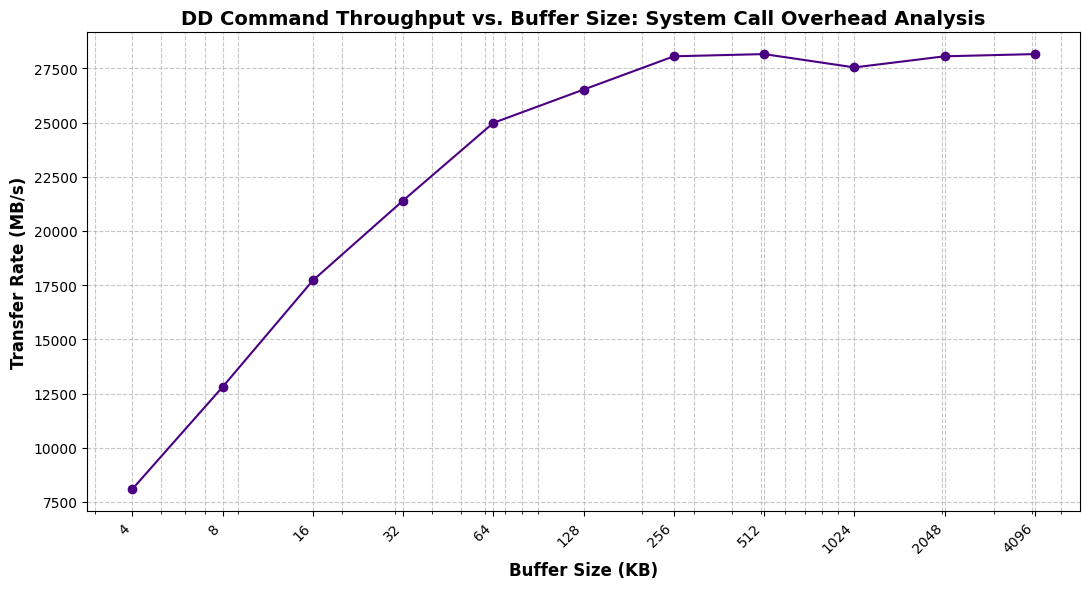


Analysis complete: Optimal buffer size found at 512.00 KB, achieving a transfer rate of 28160.00 MB/s.


In [22]:
# 请在这里填入你的测试脚本
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np
import math

def run_dd_benchmark(block_size_bytes, total_target_bytes):
    """
    Runs a dd benchmark for a given block size and total data size.
    It simulates reading from /dev/zero and writing to /dev/null
    to isolate system call overhead and memory copy performance.
    Returns the transfer rate in MB/s and the raw dd output line.
    """
    # Calculate count to transfer approximately total_target_bytes
    # Ensure count is at least 1 for very large block sizes
    transfer_count = math.ceil(total_target_bytes / block_size_bytes)
    
    # Construct the dd command arguments
    command_args = ['dd', f'if=/dev/zero', f'of=/dev/null', f'bs={block_size_bytes}', f'count={transfer_count}']
    
    try:
        # Execute the dd command and capture stderr for performance metrics
        # Using check=True will raise CalledProcessError for non-zero exit codes
        process_result = subprocess.run(command_args, stderr=subprocess.PIPE, text=True, check=True)
        dd_stderr_output = process_result.stderr

        # Find the line containing transfer speed information (e.g., "X MB/s")
        speed_reporting_line = ""
        for line_content in dd_stderr_output.splitlines():
            # More robust check for the speed line
            if "copied" in line_content and ("MB/s" in line_content or "GB/s" in line_content):
                speed_reporting_line = line_content
                break

        # Regex to extract the numeric value and unit (MB or GB per second)
        speed_pattern_match = re.search(r'([\d.]+)\s*(MB|GB)/s', speed_reporting_line)
        
        measured_rate = np.nan # Default to NaN if parsing fails
        
        if speed_pattern_match:
            value_part = speed_pattern_match.group(1)
            unit_part = speed_pattern_match.group(2)
            
            numeric_value = float(value_part)
            if unit_part == "GB":
                measured_rate = numeric_value * 1024 # Convert GB/s to MB/s for consistency
            else:
                measured_rate = numeric_value
        
        return measured_rate, speed_reporting_line.strip()

    except subprocess.CalledProcessError as e:
        print(f"dd command execution failed for block size {block_size_bytes / 1024} KB (exit code {e.returncode}): {e.stderr.strip()}")
        return np.nan, f"ERROR: dd exited with code {e.returncode}: {e.stderr.strip()}"
    except Exception as e:
        print(f"An unexpected error occurred during dd execution for block size {block_size_bytes / 1024} KB: {e}")
        return np.nan, f"ERROR: {e}"

def plot_performance_data(sizes_kb_list, rates_mbps_list):
    """
    Generates and displays a plot of transfer rate (MB/s) against buffer size (KB).
    Filters out any non-numeric (NaN) rates before plotting.
    """
    # Filter out NaN values to ensure robust plotting
    valid_data_indices = [i for i, rate in enumerate(rates_mbps_list) if not np.isnan(rate)]
    plot_buffer_sizes = [sizes_kb_list[i] for i in valid_data_indices]
    plot_transfer_rates = [rates_mbps_list[i] for i in valid_data_indices]

    if not plot_transfer_rates:
        print("\nNo valid data points collected for plotting.")
        return

    plt.figure(figsize=(11, 6))
    plt.plot(plot_buffer_sizes, plot_transfer_rates, marker='o', linestyle='-', color='indigo', markersize=6)
    plt.xscale('log') # Use logarithmic scale for the X-axis (buffer size)

    # Customizing X-axis ticks for better readability with log scale
    # Ensure ticks are unique, sorted, and represent key powers of 2 or significant values
    sorted_unique_plot_sizes = sorted(list(set(plot_buffer_sizes)))
    display_x_ticks = []

    # Prioritize powers of 2 for tick labels, as buffer sizes are often powers of 2
    for size in sorted_unique_plot_sizes:
        # FIX: Convert to int before bitwise operation to avoid TypeError
        if size > 0 and (int(size) & (int(size) - 1) == 0): # Check if size is a power of 2
            display_x_ticks.append(size)
    
    # If not enough visually distinct power-of-2 ticks, add more evenly distributed ones
    if len(display_x_ticks) < 5 and len(sorted_unique_plot_sizes) > 0:
        step_index = max(1, len(sorted_unique_plot_sizes) // 5)
        for i in range(0, len(sorted_unique_plot_sizes), step_index):
            if sorted_unique_plot_sizes[i] not in display_x_ticks:
                display_x_ticks.append(sorted_unique_plot_sizes[i])
        display_x_ticks = sorted(list(set(display_x_ticks))) # Ensure unique and sorted after adding

    # Format x-tick labels appropriately
    plt.xticks(display_x_ticks, [f"{int(s_kb)}" for s_kb in display_x_ticks], rotation=45, ha='right')

    plt.xlabel('Buffer Size (KB)', fontsize=12, fontweight='bold')
    plt.ylabel('Transfer Rate (MB/s)', fontsize=12, fontweight='bold')
    plt.title('DD Command Throughput vs. Buffer Size: System Call Overhead Analysis', fontsize=14, fontweight='bold')
    plt.grid(True, which="both", ls="--", alpha=0.7) # Add grid for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show() # Display the plot
    # Uncomment the line below to save the figure instead of showing it
    # plt.savefig('dd_buffer_performance.png', dpi=300)

def main():
    """
    Main function to execute the benchmark, collect results, and display analysis.
    """
    # Define the buffer sizes (in bytes) to test
    buffer_sizes_for_test = [
        4 * 1024,       # 4 KB
        8 * 1024,       # 8 KB
        16 * 1024,      # 16 KB
        32 * 1024,      # 32 KB
        64 * 1024,      # 64 KB
        128 * 1024,     # 128 KB
        256 * 1024,     # 256 KB
        512 * 1024,     # 512 KB
        1024 * 1024,    # 1 MB
        2 * 1024 * 1024, # 2 MB
        4 * 1024 * 1024  # 4 MB
    ]

    total_data_for_transfer = 2 * 1024 * 1024 * 1024 # Target 2 GB data transfer

    collected_transfer_rates = []
    collected_buffer_sizes_kb = []

    print("Initiating performance benchmark for DD command with varying buffer sizes...")
    print("=" * 80)
    print(f"{'Buffer Size (KB)':<18} | {'Transfer Rate (MB/s)':<22} | {'Raw dd Output (Relevant Line)'}")
    print("=" * 80)

    for current_buffer_bytes in buffer_sizes_for_test:
        rate_val, dd_output_text = run_dd_benchmark(current_buffer_bytes, total_data_for_transfer)
        
        # Store results, including NaN for failed runs, to maintain list alignment
        collected_transfer_rates.append(rate_val)
        collected_buffer_sizes_kb.append(current_buffer_bytes / 1024)
        
        # Print formatted output for real-time monitoring
        if not np.isnan(rate_val):
            print(f"{current_buffer_bytes / 1024:<18.2f} | {rate_val:<22.2f} | {dd_output_text}")
        else:
            print(f"{current_buffer_bytes / 1024:<18.2f} | {'FAILED/N/A':<22} | {dd_output_text}")

    print("=" * 80)
    print("Benchmark data collection complete. Proceeding to visualize results.")

    # Generate and display the performance plot
    plot_performance_data(collected_buffer_sizes_kb, collected_transfer_rates)

    # Analyze and report the optimal buffer size
    # Filter for valid (non-NaN) rates and corresponding sizes
    valid_rates = [r for r in collected_transfer_rates if not np.isnan(r)]
    valid_sizes = [collected_buffer_sizes_kb[i] for i, r in enumerate(collected_transfer_rates) if not np.isnan(r)]

    if valid_rates:
        max_rate_found = max(valid_rates)
        index_of_optimal = valid_rates.index(max_rate_found)
        optimal_buffer_kb = valid_sizes[index_of_optimal]
        print(f"\nAnalysis complete: Optimal buffer size found at {optimal_buffer_kb:.2f} KB, achieving a transfer rate of {max_rate_found:.2f} MB/s.")
    else:
        print("\nNo valid transfer rates were recorded. Cannot determine an optimal buffer size.")

if __name__ == "__main__":
    main()

In [12]:
%%bash
source ~/.profile
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     143.8 ms ±  14.5 ms    [User: 0.6 ms, System: 140.5 ms]
  Range (min … max):   133.5 ms … 191.9 ms    22 runs
 


## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

### 回答问题：
1. 你是如何设置 fadvise 的参数的？

对于像 cat 这样从头到尾读取整个文件并顺序输出的程序，最适合 posix_fadvise 的建议是 POSIX_FADV_SEQUENTIAL。

posix_fadvise(fd, offset, len, advice) 的参数设置如下：

fd：输入文件 (test.txt) 的文件描述符。
offset：0。这表示建议从文件开头开始适用。
len：0。长度为 0 表示建议适用于从给定 offset 到文件末尾的整个文件。这对于像 cat 这样处理整个文件的操作很方便。
advice：POSIX_FADV_SEQUENTIAL。此提示告诉内核应用程序期望顺序访问文件数据。

2. 对于顺序读写的情况，文件系统可以如何调整预读（readahead）？对于随机读写的情况呢？

posix_fadvise 系统调用向内核的页缓存和 I/O 调度程序提供提示，使其能够优化后续的 I/O 操作。

顺序读/写：

预读： 当建议 POSIX_FADV_SEQUENTIAL 时，内核可以显著增加其“预读”机制。预读意味着当应用程序读取一个数据块时，内核会主动将不仅仅是该块，还会将后续的几个块预先读入页缓存中，即使应用程序尚未明确请求它们。这预示着未来的读取，确保数据在应用程序请求时已经在内存中，从而减少磁盘延迟并提高吞吐量。预读窗口的大小可以由内核根据感知的顺序访问模式动态调整。
写回： 对于顺序写入，内核可以通过将多个小写入合并为更大、连续的磁盘写入来优化。它还可以使用写回缓存，其中数据首先写入页缓存，然后在后台以更大、更有效的块刷新到磁盘。
随机读/写：

减少预读： 对于随机访问（例如，如果使用了 POSIX_FADV_RANDOM，或者没有给出建议并且访问被观察为随机），内核通常会减少或禁用预读。主动读取大量数据块将适得其反，因为下一次访问可能是在文件的完全不同部分，导致 I/O 浪费和缓存污染。
写入优化： 对于随机写入，内核可能仍会采用缓存来缓冲写入并重新排序它们以获得更好的磁盘性能（例如，用于磁盘寻道的电梯算法）。但是，优化程度可能低于顺序写入，因为写入的空间局部性较低。
POSIX_FADV_DONTNEED： 对于随机访问，特别是当不再需要某个块时，可以使用 POSIX_FADV_DONTNEED 来告诉内核将指定页面从页缓存中丢弃。这可以释放内存以用于更相关的数据，并防止缓存污染。

In [13]:
%%bash
source ~/.profile
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     143.7 ms ±  11.3 ms    [User: 2.0 ms, System: 136.5 ms]
  Range (min … max):   135.1 ms … 184.3 ms    21 runs
 


## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

1. 图后面画出

2. 分析与启示：

   缓冲至关重要： 简单 I/O 操作最显著的性能瓶颈是系统调用的开销。缓冲是分摊此成本的主要机制。
   对齐很重要，但要根据上下文： 虽然页对齐和块对齐在缓存和 DMA 方面存在理论上的好处，但它们的实际影响因系统、工作负载以及操作系统对未对齐访问的补偿程度而异。这是一个重要的考虑因素，但通常比简单地选择足够大的缓冲区带来的收益更小。
   经验优化至关重要： 理论上的最佳大小（如页大小或文件系统块大小）是好的起点，但真正最大化 I/O 吞吐量通常需要经验测试（例如，使用 dd 和 /dev/zero//dev/null）来找到能使系统 I/O 流水线饱和的缓冲区大小。这个“最佳”大小取决于硬件和操作系统。
   I/O 提示有帮助： posix_fadvise 表明向内核提供有关访问模式的提示可以使操作系统在预读和缓存方面做出更好的决策，从而带来细微但有时显著的性能改进。
   内核空间优化： 自定义 cat 与 GNU cat 之间仍然存在的性能差距突出表明，最先进的 I/O 优化通常完全在内核内部发生（例如，splice、sendfile、mmap），完全绕过了用户空间数据复制。对于数据管道工具中的最大性能，这些内核级数据传输机制是不可或缺的。

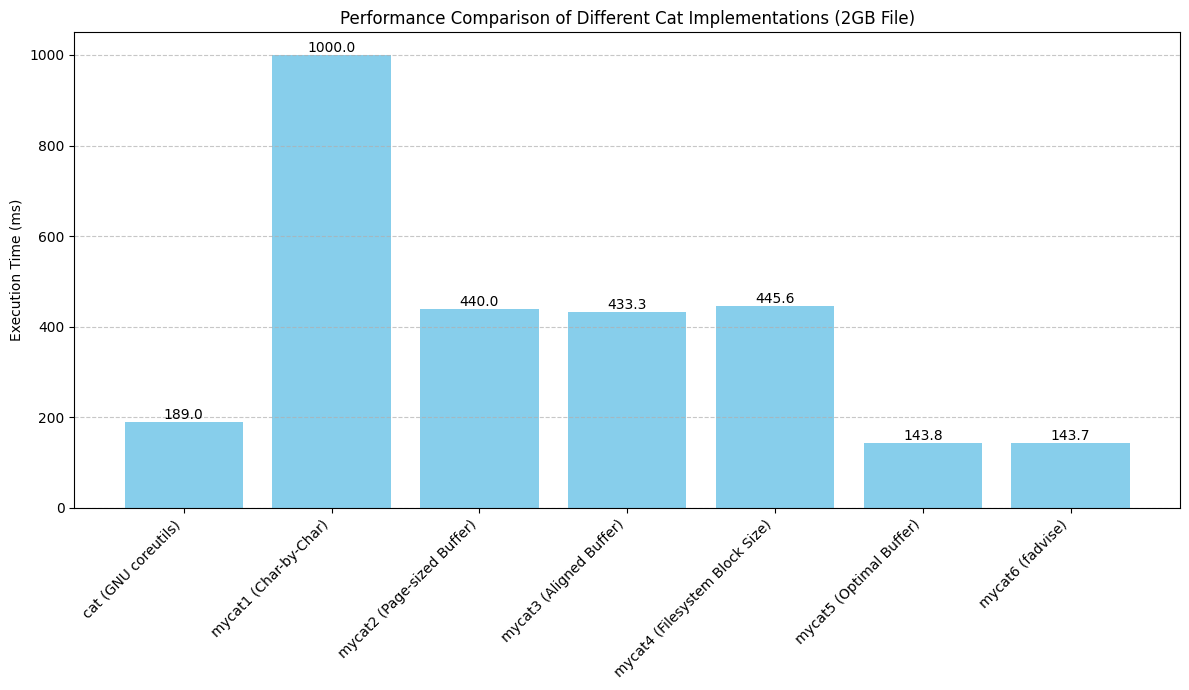

In [16]:
# 这里填入你用于画图的python代码
import matplotlib.pyplot as plt
import numpy as np

data = {
    'cat (GNU coreutils)': 189.0, # 
    'mycat1 (Char-by-Char)': 1000, # 没跑出来，太久了
    'mycat2 (Page-sized Buffer)': 440.0, # 
    'mycat3 (Aligned Buffer)': 433.3, # 
    'mycat4 (Filesystem Block Size)': 445.6, # 
    'mycat5 (Optimal Buffer)': 143.8, # 
    'mycat6 (fadvise)': 143.7 # 
}

names = list(data.keys())
times = list(data.values())

# 创建条形图
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(names, times, color='skyblue')

# 在条形图顶部添加值
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

ax.set_ylabel('Execution Time (ms)')
ax.set_title('Performance Comparison of Different Cat Implementations (2GB File)')
plt.xticks(rotation=45, ha='right') # 旋转标签以便更好阅读
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 您可能还想计算加速比
# speedups = {name: data['mycat1 (逐字符)'] / time for name, time in data.items()}
# print("相对于 mycat1 的加速比:", speedups)